# Data Cleaning Challenge

Thinkful Bootcamp Course

Author: Ian Heaton

Email: iheaton@gmail.com

Mentor: Nemanja Radojkovic

Date: 2017/02/16


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

Below is the Python code that performs all of the heavy lefting to clean and Impute the Wellcome trust journal data.

In [25]:
PMCregex = r'PMC\d+'
PMIDregex = r'PMID:\s?\d+'

# The dictionary serves to convert publisher and journal names into the most
# common occurrences contained with the CSV file. For example converting
# abbreviated journal names to the full name. Note, these may not be accurate.
# The keys assume that text has been converted to lower case and then converted
# to title case.  In other words, the keys do not exist in the raw file until
# they have ran through the convert_journal_pub_names function.

PUB_JOURNAL_LOOKUP = {
    'Acs': 'American Chemical Society',
    'Acs (Amercian Chemical Society) Publications': 'American Chemical Society',
    'Asm': 'American Society for Microbiology',
    'Biomed Central Limited': 'BioMed Central',
    'Biomed Central Ltd':'BioMed Central',
    'Bmj':'British Medical Journal',
    'Bmj Group':'British Medical Journal',
    'Bmj Publishing Group':'British Medical Journal',
    'Bmj Publishing Group Ltd':'British Medical Journal',
    'Cadmus':'Cadmus Journal Services',
    'Cambridge Journals':'Cambridge University Press',
    'Cambridge Uni Press':'Cambridge University Press',
    'Cambridge Univ Press':'Cambridge University Press',
    'Cenveo Publisher Services/ASM JV1': 'Cenveo Publisher Services',
    'Cold Spring Habour Press':'Cold Spring Harbor Laboratory Press',
    'Cold Spring Harbor Press':'Cold Spring Harbor Laboratory Press',
    'Cold Spring Harbor Publications':'Cold Spring Harbor Laboratory Press',
    'Dartmouth Journals':'Dartmouth Journal Services',
    'Elseveier Science':'Elsevier',
    'Faseb':'Federation of American Societies for Experimental Biology',
    'Federation of American Societies for Experimental Biology (FASEB)':'Federation of American Societies for Experimental Biology',
    'Oup':'Oxford University Press',
    'Oxford Univ Pres':'Oxford University Press',
    'Oxford Journals':'Oxford University Press',
    'Oxford Journals (OUP)':'Oxford University Press',
    'Plos':'Public Library of Science',
    'Plos (Public Library of Science)':'Public Library of Science',
    'Royal Society': 'Royal Society of Chemistry',
    'Rsc':'Royal Society of Chemistry',
    'Rsc Publishing':'Royal Society of Chemistry',
    'Aids':'Journal of Acquired Immune Deficiency Syndromes',
    'Aids Journal':'Journal of Acquired Immune Deficiency Syndromes',
    'Aids UK':'Journal of Acquired Immune Deficiency Syndromes',
    'Jaids Journal of Acquired Immune Deficiency Syndromes':'Journal of Acquired Immune Deficiency Syndromes',
    'Journal of Acquired Immune Deficiency Syndroms (JAIDS)':'Journal of Acquired Immune Deficiency Syndromes',
    'Journal of AIDS':'Journal of Acquired Immune Deficiency Syndromes',
    'Plos 1':'Plos One',
    'Neuroimage':'NeuroImage'
}

def retrieve_metadata(dataframe):
    """
     Extracts the shape, column names and number of null rows for
     each column of a Pandas data frame. This information is printed
     to standard ouput.

     Args:
        dataframe (dataframe): The Pandas data frame of interest

     Returns:
        Nothing
    """
    num_rows, num_columns = dataframe.shape
    columns = dataframe.columns.values.tolist()
    print('Data frame contains %d columns and %d rows' % (num_columns, num_rows))
    for elem in columns:
        print('column %s has %d empty rows'% (elem, sum(dataframe[elem].isnull())))


def _search_pmcid_regex(id_str):
    """
    Tries to match the string containing the journal ID against
    a PMCID regex. Returns the first instance of a match.

     Args:
        id_str (str): Cell contents of the ‘'PMID/PMCID' column.

     Returns:
       tuple: A tuple containing boolean and string containing
       the new ID.  The boolean may have a value of true indicating
       that a sub string matched the regular expression or false otherwise.
       If false the match str is empty.
    """
    result = False
    match_str = ''
    try:
        match_str = re.search(PMCregex, id_str).group()
        result = True
    except AttributeError:
        pass
    return result, match_str


def _search_pmid_regex(id_str):
    """
     Tries to match the string containing the journal ID against
    a Pub Med regex. Returns the first instance of a match.

     Args:
        id_str (str): Cell contents of the ‘'PMID/PMCID' column.

     Returns:
       tuple: A tuple containing boolean and string containing
       the new ID.  The boolean may have a value of true indicating
       that a sub string matched the regular expression or false otherwise.
       If false the match str is empty.
    """
    result = False
    match_str = ''
    try:
        match_str = re.search(PMIDregex, id_str).group()
        match_str = match_str.replace(':', '')
        match_str = match_str.replace(' ', '')
        result = True
    except AttributeError:
        pass
    return result, match_str


def pmcid_pmid_converter(id_str):
    """
     Specialized data massaging function for Wellcome trust data.
     This function should only be run on the first column containing
     the label ‘PMC ID/PMID’.
     The following assumptions and conversions are carried out;

        1. Those id numbers starting with 3 are PMCID ids
        2. Those id numbers starting with 2 are PMID ids
        3. Those ids without prefix will have either PMIC or PMID appended
        4. NA values will be kept
        5. Any other text in a row that does not adherer to the above two
           forms will be dropped and replaced with NA.
        6. Cells that have both PMIC and PMID identifiers will have
           the 2nd id dropped. Only one id is necessary.

     Args:
        id_str (str): String instance containing a cells entire text.

     Returns:
        str: string instance containing either NA, PMCID* or PMID*
    """
    data = str(id_str)
    data = data.strip('\n')
    has_pmcid_match = False
    has_pmid_match = False
    match_pmcid_str = ''
    match_pmid_str = ''
    result_str = ''

    has_pmcid_match, match_pmcid_str = _search_pmcid_regex(data)
    has_pmid_match, match_pmid_str = _search_pmid_regex(data)

    if has_pmcid_match or has_pmid_match:
        if has_pmcid_match:
            result_str = match_pmcid_str
        elif has_pmid_match:
            result_str = match_pmid_str
    elif data.isdigit():
        if data[0] == '2':
            result_str = 'PMID' + data
        elif data[0] == '3':
            result_str = 'PMCID' + data
    else:
        result_str = 'NA'

    return result_str


def remove_money_symbols(string):
    """
    Removes the pound symbol and trailing dollar sign symbols from
    the Cost data. Resulting data is converted to type float.

    Args:
        string (str): string instance housing cell contents.

    Returns:
        float: Cost of journal article represented as a float
    """
    string = string.replace('$', '')
    return float(string[1:])


def remove_cost_outliers(cost, threshold):
    """
    Sets any cost values that are equal to or greater than threshold
    to NaN (Not a Number). Any values that less than one are also set
    to not a number.

    Args:
        cost (float):           cost value to be capped.
        threshold (decimal):    Outlier threshold

    Returns:
        float: Resulting NaN
    """
    result = cost
    if cost >= threshold or cost < 1:
        result = float('nan')
    return result


def convert_journal_pub_names(string):
    """
    Converts journal and Publication names into title case and transforms string
    into a generalized name. These generalized terms are housed in a dictionary
    and exchanged for the most least used term or mis spelled text. For example
    changing ‘Neuroimgae’ into ‘NeuroImage’

    Args:
        string (str): Publication or Journal column cell contents.

    Returns:
        str: The converted cell contents as a string instance.
    """
    string = str(string)
    string = string.lower()
    result = string.title()
    if result in PUB_JOURNAL_LOOKUP:
        result = PUB_JOURNAL_LOOKUP.get(result)
    return result

### Step 1

Data is read in from the CSV file and set of meta data is retrieved from the data frame to get an idea on the amount of missing data.  A function is then applied to the data of the ‘PMID/PMCID’ column that convert each cell text to either PMC*, PMID* or NA. 

In [26]:
file_path = '/media/ianh/space/ThinkfulData/WelcomeTrust/WELLCOME_APCspend2013_forThinkful.csv'
data_frame = pd.read_csv(file_path)
retrieve_metadata(data_frame)

Data frame contains 5 columns and 2127 rows
column PMID/PMCID has 199 empty rows
column Publisher has 0 empty rows
column Journal title has 1 empty rows
column Article title has 0 empty rows
column COST (�) charged to Wellcome (inc VAT when charged) has 0 empty rows


In [27]:
NewIDColumn_Df = pd.DataFrame({'ID':data_frame['PMID/PMCID'].apply(pmcid_pmid_converter)})
retrieve_metadata(NewIDColumn_Df)

Data frame contains 1 columns and 2127 rows
column ID has 0 empty rows


### Step 2

The cost column is now altered to remove any money symbols and converted to float so that proper statistics can be performed on the column. Next a boxplot is created for the Journal costs to identify the range of values and to find any outliers. 

It is obvious from the describe method and the box plot that any value over 4000 pounds is an outlier. In fact the resulting plot had to have its x axis limited to 5000 to visualize the box plot correctly. 


                Cost
count    2127.000000
mean    24060.945990
std    146861.672509
min         0.000000
25%      1272.925000
50%      1883.710000
75%      2321.305000
max    999999.000000


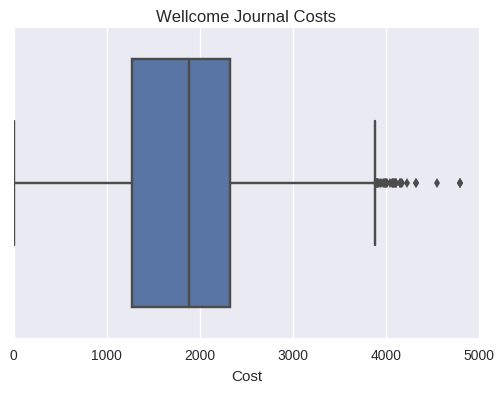

In [28]:
column_name = 'COST (�) charged to Wellcome (inc VAT when charged)'
NewCost1stPass_Df = pd.DataFrame({'Cost':data_frame[column_name].apply(remove_money_symbols)})
print(NewCost1stPass_Df.describe())
sns.boxplot(x="Cost", data=NewCost1stPass_Df)
sns.plt.title('Wellcome Journal Costs')
sns.plt.xlim(0, 5000)
plt.show()

Any values that are equal to zero or greater than the 4th quartile are set to ‘NaN’ and thereafter dropped from any further analysis.  Since we have do not have any idea what the proper amount for the journal coast it seems safer to drop these rows from analysis then assigning the max or mean value to these.

In [30]:
NewCost2ndPass_df = pd.DataFrame({'Cost':NewCost1stPass_Df['Cost'].apply(remove_cost_outliers, args=(2500,))})
NewCost2ndPass_df.describe()

,Cost
count,1866.000000
mean,1647.321715
std,584.959255
min,9.930000
25%,1156.845000
50%,1759.185000
75%,2132.922500
max,2498.610000


### Step 3

The last processing step is the amalgamation of the newly created data frames in a larger data frame containing all of the columns so that statistics can be run on the data. 

In [31]:
NewPublisherColumn_Df = pd.DataFrame({'Publisher':data_frame['Publisher'].apply(convert_journal_pub_names)})
NewJournalColumn_Df = pd.DataFrame({'Journal title':data_frame['Journal title'].apply(convert_journal_pub_names)})

In [32]:
NewIDColumn_Df['Cost'] = NewCost2ndPass_df['Cost']
NewIDColumn_Df['Publisher'] = NewPublisherColumn_Df['Publisher']
NewIDColumn_Df['Journal title'] = NewJournalColumn_Df['Journal title']
NewIDColumn_Df['Article title'] = data_frame['Article title']

### Step 4 Statistical processing

#### 1. Determine the most and least expensive journals and publishers

In [33]:
max_cost = NewIDColumn_Df['Cost'].max()
print(NewIDColumn_Df[(NewIDColumn_Df.Cost == max_cost)])

             ID     Cost Publisher       Journal title  \
483  PMC3639368  2498.61  Elsevier  Brain And Language   

                                         Article title  
483  Current themes in neuroimaging studies of Reading  


In [34]:
min_cost = NewIDColumn_Df['Cost'].min()
print(NewIDColumn_Df[(NewIDColumn_Df.Cost == min_cost)])

             ID  Cost       Publisher        Journal title  \
243  PMC3716626  9.93  BioMed Central  Veterinary Research   

                                         Article title  
243  Understanding foot-and-mouth disease virus tra...  


#### 2. Determine mean and median of open-access price paid per article

In [35]:
NewIDColumn_Df['Cost'].describe()

count    1866.000000
mean     1647.321715
std       584.959255
min         9.930000
25%      1156.845000
50%      1759.185000
75%      2132.922500
max      2498.610000
Name: Cost, dtype: float64